## plot spatial ACC pattern of DPLE

In [1]:
import matplotlib.colors as colors
from matplotlib import cm,gridspec,rc
import matplotlib.pyplot as plt
import os
import utils
import warnings
import cartopy.crs as ccrs
import numpy as np
import pandas as pd
import xarray as xr
import corrstats
warnings.filterwarnings('ignore')

# Model Grid for region mask to remove values that are not good

In [2]:
USER = os.environ['USER']

In [3]:
path = f'/glade/u/home/{USER}/O2prediction/Prediction/notebooks/data'
filename = f'{path}/grid-data-POP_gx1v6.nc'
grid = xr.open_dataset(filename)
region_mask = grid['REGION_MASK']
#lon = grid.coords['TLONG']
#lat = grid.coords['TLAT']

In [4]:
path = f'/glade/work/{USER}/MAPP/ETOPO'
filename = f'{path}/Etopo1_Bed_0_65N_170E_40W.nc'
bathy = xr.open_dataset(filename)
lon_e = bathy['lon']
for ii in range(len(lon_e)):
    if lon_e[ii] > 0:
        lon_e[ii] = lon_e[ii] - 360.
lat_e = bathy['lat']
depth_e = bathy['depth']

In [5]:
mask_bathy = (depth_e >= 0.)*1.
mask_bathy = np.ma.array(mask_bathy,mask=mask_bathy==0.)
lon_e,lat_e = np.meshgrid(lon_e,lat_e)
lon_e = np.ma.array(lon_e,mask=mask_bathy.mask)
lat_e = np.ma.array(lat_e,mask=mask_bathy.mask)

In [6]:
import matplotlib as mpl
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    '''
    https://stackoverflow.com/a/18926541
    '''
    if isinstance(cmap, str):
        cmap = plt.get_cmap(cmap)
    new_cmap = mpl.colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

In [7]:
new_cmapt = truncate_colormap('PuBuGn_r', 0., 1.0)
new_cmaps = truncate_colormap('PuOr_r', 0.375, 1.0)

In [8]:
lat_min = 15;   lat_max = 65
lon_min = -190; lon_max = -40
#
cmin = 0.;cmax = 1.;clev = 20.
dc = (cmax - cmin)/clev; vct = np.arange(cmin, cmax+dc, dc)
pal_normt = colors.BoundaryNorm(vct, ncolors=256, clip = False)
#
cmin = -.25;cmax = 1;clev = 25.
dc = (cmax - cmin)/clev; vcs = np.arange(cmin, cmax+dc, dc)
pal_norms = colors.BoundaryNorm(vcs, ncolors=256, clip = False)
# text
#rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('font',**{'family':'serif','serif':['Times']})
rc('text', usetex=True)
#csfont = {'fontname':'Times New Roman'}

## read clim BSF

In [9]:
var_name = 'BSF'
a1,a2,b1,b2 = [240,380,125,320]
datadir = f'/glade/scratch/{USER}/DPLE-results'
filename = f'{datadir}/DPLE-forcing_{var_name}_hindcast_clim.nc'
ds_hind = xr.open_dataset(filename)
nmon = ds_hind.dims['time']
bsf = ds_hind['BSF'][a1:a2,b1:b2]

## LME Shapes

In [10]:
path = f'/glade/u/home/{USER}/O2prediction/Prediction/notebooks/data'
filename = '%s/LME_shapes.gmt' % path
file1 = open(filename,'r')
lines = file1.readlines()
#
nbox = -1
lonn = [[] for ii in range(194)]
latt = [[] for ii in range(194)]
ln = 9
for line in lines[ln:]:
    sl = line.split()
    if len(sl)==2 and sl[0] == '#':
        nbox = nbox + 1
    elif len(sl)==2 and sl[0] != '#':
        lonn[nbox-1].append(np.float(sl[0]))
        latt[nbox-1].append(np.float(sl[1]))
##
pp180 = []
for pp in range(len(lonn)):
    if len(lonn[pp])>0:
        if np.min(lonn[pp])>0:
            lon1 = np.array(lonn[pp]) - 360.
        else:
            lon1 = np.array(lonn[pp])
        if len(np.where(np.abs(lon1 + 180.)<1e-4)[0])>0:
            if len(lonn[pp])<4:
                pp180.append(pp)
##
lon0 = []
lat0 = []
nn = 0
for pp in range(len(lonn)):
    if len(lonn[pp])!=0:
        nn = nn + 1
        if np.min(lonn[pp])>0:
            lon1 = np.array(lonn[pp]) - 360.
        else:
            lon1 = np.array(lonn[pp])
        lat1 = np.array(latt[pp])
        lon1 = np.ma.array(lon1,mask=False)
        lat1 = np.ma.array(lat1,mask=False)
        if pp in pp180[1:]:
#        if len(np.where(np.abs(lon1+180.)<1e-4)[0]) > 0:
            #print(pp)
            aa = np.where(np.abs(lon1+180.)<1e-4)[0]
            lon1.mask[aa] = True
            lat1.mask[aa] = True
        lon0.append(lon1)
        lat0.append(lat1)

In [11]:
def mask_nan(var):
    """
    mask nan values
    """
    maskn = np.isnan(var)
    var = np.ma.array(var,mask=maskn)
    return var

In [12]:
var = 'Phi'
unit = ''

0.16710531273118748 1.3818681447487084
0.04201252843633258 2.4713524012495522
-1.6761889289895335 0.7307212999899237
0.26384969409196224 1.3822210400492612
0.12140643180874104 1.7654730496248996
-0.8034255217010711 0.6906661181387178
0.4030313196666148 1.5356039696474697
0.22434408909501247 1.8559870069183733
-0.8158694836072726 0.7062371815035304
0.44596305141903386 1.5526402584341685
0.37505851186280237 3.3368842028182626
-2.3562996286343765 0.7052547844782303
0.5412865598202397 1.672700224902978
0.4142723993003783 3.8952327639541013
-2.8291895979950237 0.8723040948118531
0.07258146056745624 1.1767563312682996
0.027135606834630534 1.807971462720683
-1.483619917056805 0.7536425740198189
0.13602332212382426 1.346761454287656
0.05228466449313956 5.183340371540635
-4.781123914001141 0.7699808967401232
0.2610692049252183 1.4311320748642231
0.07652786941580435 6.725017710285063
-6.174720606617086 0.774889368644267
0.4430345129865342 1.5620475441093062
0.09641949610667426 5.537843562581189


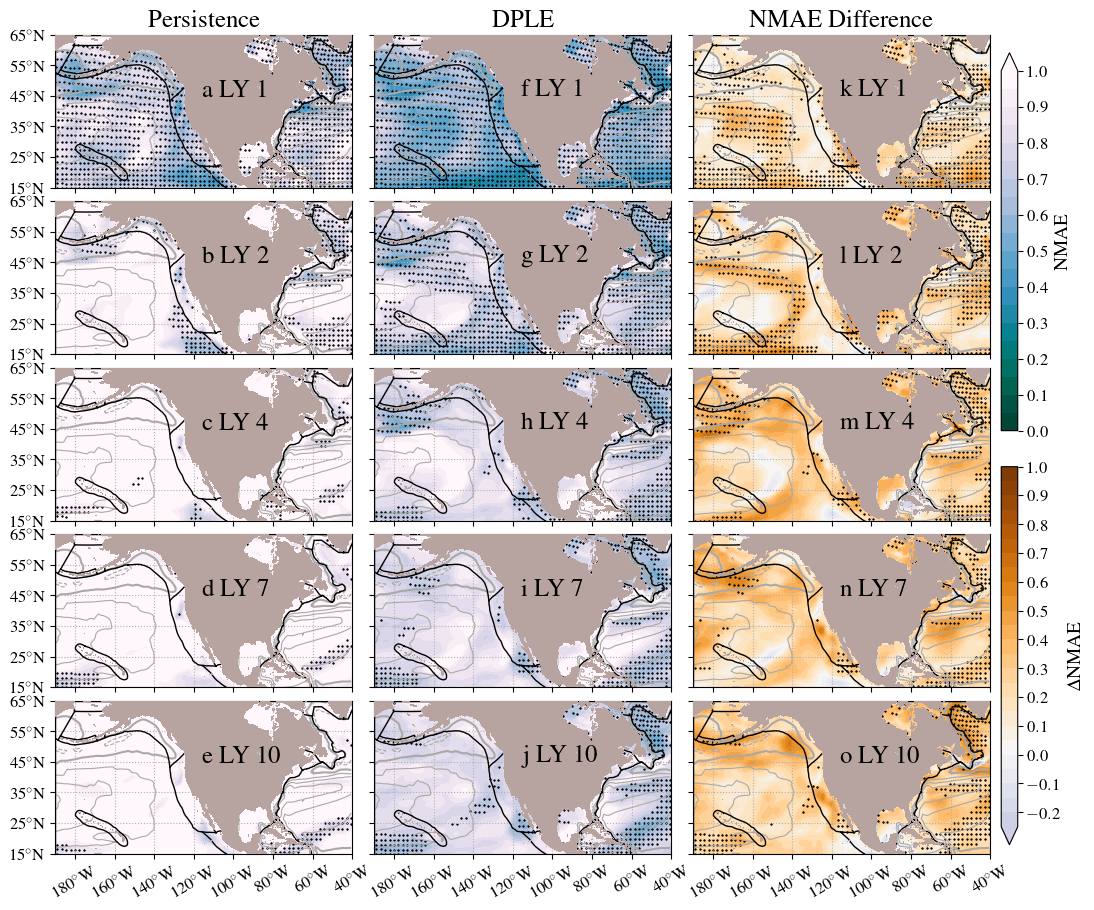

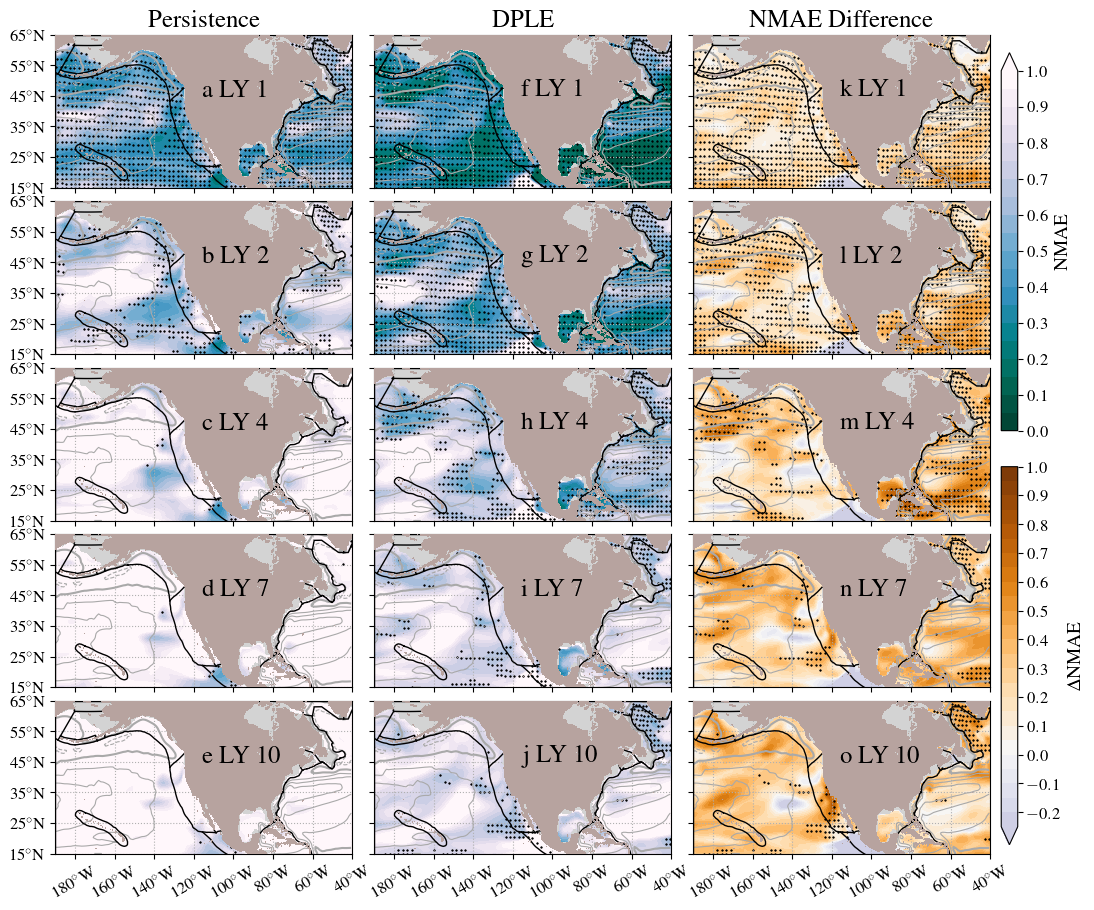

In [13]:
ngg = [['a', 'f', 'k'],\
       ['b', 'g', 'l'],\
       ['c', 'h', 'm'],\
       ['d', 'i', 'n'],\
       ['e', 'j', 'o']]
#
nphi = 1
for layer in ['0-200m', '200-600m']:
    fig = plt.figure(figsize=[11, 9])
    gs = gridspec.GridSpec(5, 3)#, width_ratios=[1, 1, 1, 1e-2])
    # read ACC data
    # Persistence and DPLE ACC
    datadir = f'/glade/scratch/{USER}/DPLE-results'
    filename = f'{datadir}/DPLE_spatial_persistence_DPLE_ACC_{var}_{layer}_leadyear1-10_new_method2.nc' # % (datadir,var_name)
    ds_fore = xr.open_dataset(filename)
    corr_p = ds_fore['corr_p'].values[nphi, :]
    rcri_p = ds_fore['rcri_p'].values[nphi, :]
    corr_d = ds_fore['corr_d'].values[nphi, :]
    rcri_d = ds_fore['rcri_d'].values[nphi, :]
    corr13 = ds_fore['corr13'].values[nphi, :]
    rcri13 = ds_fore['rcri13'].values[nphi, :]
    nmae_p = ds_fore['nmae_p'].values[nphi, :]
    nmae_d = ds_fore['nmae_d'].values[nphi, :]
    lon = ds_fore['lon'].values
    lat = ds_fore['lat'].values
    #
    corr_p = mask_nan(corr_p);rcri_p = mask_nan(rcri_p)
    corr_d = mask_nan(corr_d);rcri_d = mask_nan(rcri_d)
    corr13 = mask_nan(corr13);rcri13 = mask_nan(rcri13)
    #
    corr_f = corr_d - corr_p
    nmae_f = nmae_p - nmae_d
    #
    pmask = corr_p >= rcri_p
    # Test ACC difference significance
    lenn = 2007+1-1954
    t_cr, p_cr = corrstats.dependent_corr(corr_p, corr_d, corr13, lenn-1, twotailed=False, method='steiger')
    #
    alpha = 0.05
    smask = p_cr <= alpha
    maskk = corr_d >= rcri_d
    maskp = corr_f > 0.
    ## plot
    lyy = np.array([0, 1, 3, 6, 9])
    for gg, ldd in zip(range(5), lyy):
        for vv, mm, tit in [[nmae_p, 0, 'Persistence'], [nmae_d, 1, 'DPLE'], [nmae_f, 2, 'NMAE Difference']]:
        ## persistence lead year 1-5
        ## DPLE lead year 1-5
        ## DPLE - persistence difference
            #ax = fig.add_subplot(gs[gg, mm])
            if mm < 2:
                ax = fig.add_axes([0.06+mm*0.29, 0.05+(4-gg)*0.185, 0.27, 0.17])
            else:
                ax = fig.add_axes([0.06+mm*0.29, 0.05+(4-gg)*0.185, 0.27, 0.17])
            #
            xrr = np.arange(lon_min-10, lon_max+10)
            ax.fill_between(xrr, np.ones(len(xrr))*(lat_min-10), np.ones(len(xrr))*(lat_max+10), color='lightgray')
            for pp in range(len(lon0)):
                ax.plot(lon0[pp], lat0[pp], color='k', linewidth=1., zorder=19)
            ax.contour(lon, lat, bsf, [-10], linestyles='dashed', colors='darkgray', linewidths=.8)
            ax.contour(lon, lat, bsf, [0], linestyles='solid', colors='darkgray', linewidths=1.5)
            ax.contour(lon, lat, bsf, [10, 20, 30, 40], linestyles='solid', colors='darkgray', linewidths=.8)
            if mm < 2:
                cd = ax.contourf(lon, lat, vv[ldd], vct, shading='nearest', cmap=new_cmapt, norm=pal_normt, extend='max')
            else:
                cd = ax.contourf(lon, lat, vv[ldd], vcs, shading='nearest', cmap=new_cmaps, norm=pal_norms, extend='min')
            print(np.nanmin(vv[ldd]), np.nanmax(vv[ldd]))
            #
            if mm == 0:
                lon1 = np.ma.array(lon, mask=~pmask[ldd])
                lat1 = np.ma.array(lat, mask=~pmask[ldd])
                ax.scatter(lon1[::4, ::2], lat1[::4, ::2], s=5, marker='.', color='k', alpha=1, linewidth=.5)
            elif mm == 1:
                lon1 = np.ma.array(lon, mask=~maskk[ldd])
                lat1 = np.ma.array(lat, mask=~maskk[ldd])
                ax.scatter(lon1[::4, ::2], lat1[::4, ::2], s=5, marker='.', color='k', alpha=1, linewidth=.5)
            elif mm == 2:
                lon1 = np.ma.array(lon, mask=(~maskk[ldd]+~smask[ldd]+~maskp[ldd]))
                lat1 = np.ma.array(lat, mask=(~maskk[ldd]+~smask[ldd]+~maskp[ldd]))
                ax.scatter(lon1[::4, ::2], lat1[::4, ::2], s=5, marker='.', color='k', alpha=1,linewidth=.5)#,
            #
            ax.pcolor(lon_e,lat_e,mask_bathy,shading='nearest',cmap=cm.terrain_r,vmin=.5,vmax=4,zorder=20)
            #ax.text(-130, 58, f'LY {gg+1}', fontsize=14, fontweight='bold', zorder=21)
            #ax.text(-130, 54, var, fontsize=14, fontweight='bold', zorder=21)
            ax.text(-116, 45, '%s LY %d' % (ngg[gg][mm], ldd+1), fontsize=18, fontweight='bold', zorder=21)
            ax.set_xlim(lon_min, lon_max)
            ax.set_ylim(lat_min, lat_max)
            ax.set_xticks(np.arange(-180, -30, 20))
            ax.set_yticks(np.arange(15, 66, 10))
            #if mm == 0:
            #    ax.set_ylabel('Lead Year %d' % (ldd+1), fontsize=14, fontweight='bold')
            if gg == 0:
                ax.set_title(tit, fontsize=18, fontweight='bold')
            #
            xtl = []
            for ii in np.arange(-180, -30, 20):
                if ii < -180:
                    ii = ii + 360
                    ff = 'E'
                elif ii >= -180:
                    ff = 'W'
                elif np.abs(ii-0) < 1e-5:
                    ff = ''
                xtl.append('%d$^\circ$%s' % (abs(ii), ff))
            ytl = []
            for jj in np.arange(15, 66, 10):
                if jj < 0:
                    ff = 'S'
                elif jj > 0:
                    ff = 'N'
                elif np.abs(jj-0) < 1e-5:
                    ff = ''
                ytl.append('%d$^\circ$%s' % (abs(jj), ff))
            if gg == 4:
                ax.set_xticklabels(xtl, fontsize=12, fontweight='bold', rotation=30)
            else:
                ax.set_xticklabels([], fontsize=12, fontweight='bold', rotation=30)
            if mm == 0:
                ax.set_yticklabels(ytl, fontsize=12, fontweight='bold')
            else:
                ax.set_yticklabels([], fontsize=12, fontweight='bold')
            ax.plot([lon_min, lon_max], [lat_max, lat_max], color='k', linewidth=1, zorder=10)
            ax.plot([lon_min, lon_min], [lat_min, lat_max], color='k', linewidth=1, zorder=10)
            ax.grid(linestyle='dotted', zorder=11)
        # colorbar
            if gg == 0 and mm == 1:
                cbaxes = fig.add_axes([0.92, 0.52, 0.015, 0.42])
                cb = plt.colorbar(cd, orientation="vertical", cax=cbaxes, extend='max', ticks=np.arange(-1,1.6,.1))
                cb.ax.tick_params(labelsize=12)
                cb.set_label(label='NMAE', fontsize=14, fontweight='bold')
            elif gg == 0 and mm == 2:
                cbaxes = fig.add_axes([0.92, 0.06, 0.015, 0.42])
                cb = plt.colorbar(cd, orientation="vertical", cax=cbaxes, extend='min', ticks=np.arange(-1,1.6,.1))
                cb.ax.tick_params(labelsize=12)
                cb.set_label(label='$\Delta$NMAE', fontsize=14, fontweight='bold')
    #plt.tight_layout()
    #
    output = f'/glade/scratch/{USER}/DPLE-plots'
    outfile = f'{output}/DPLE_NMAE_spatial_{var}_{nphi}_{layer}_leadyear1-5_new_method2.png'
    plt.savefig(outfile, dpi=400)
plt.show()